In [1]:
from mpl_toolkits.mplot3d import Axes3D
%pylab inline
#Import a bunch of stuff to ease command line usage
from tvb.simulator.lab import *
from tvb.basic.neotraits.api import NArray, List, Range, Final
import numpy as np
import scipy.io as sio
import scipy.signal as sig
import matplotlib.pyplot as plt
import matplotlib
import os
import multiprocessing as mp 
from matplotlib.gridspec import GridSpec
from PIL import Image
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
import time
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Initialise a Model, Coupling, and Connectivity.
oscillator = models.Generic2dOscillator()
#load the default connectivity of TVB
white_matter = connectivity.Connectivity.from_file()
#white_matter = connectivity.Connectivity.from_file('connectivity_192.zip')
white_matter.speed = numpy.array([4.0])
white_matter.configure()
white_matter_coupling = coupling.Linear(a=numpy.array(0.014))

#Initialise an Integrator
heunint = integrators.HeunStochastic(
        dt=2 ** -4,
        noise=noise.Additive(nsig=numpy.array([0.001])))

WARNING  File 'hemispheres' not found in ZIP.


<AxesSubplot:>

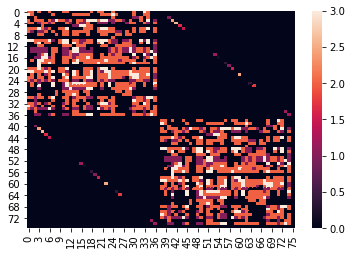

In [3]:
sns.heatmap(white_matter.weights)

<AxesSubplot:>

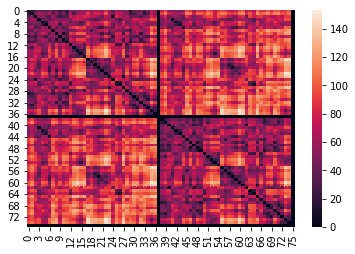

In [4]:
sns.heatmap(white_matter.tract_lengths)

In [5]:
 for n,i in enumerate(white_matter.region_labels):
     print('{n}: {i}'.format(i=i, n=n))

0: rA1
1: rA2
2: rAMYG
3: rCCA
4: rCCP
5: rCCR
6: rCCS
7: rFEF
8: rG
9: rHC
10: rIA
11: rIP
12: rM1
13: rPCI
14: rPCIP
15: rPCM
16: rPCS
17: rPFCCL
18: rPFCDL
19: rPFCDM
20: rPFCM
21: rPFCORB
22: rPFCPOL
23: rPFCVL
24: rPHC
25: rPMCDL
26: rPMCM
27: rPMCVL
28: rS1
29: rS2
30: rTCC
31: rTCI
32: rTCPOL
33: rTCS
34: rTCV
35: rV1
36: rV2
37: rCC
38: lA1
39: lA2
40: lAMYG
41: lCCA
42: lCCP
43: lCCR
44: lCCS
45: lFEF
46: lG
47: lHC
48: lIA
49: lIP
50: lM1
51: lPCI
52: lPCIP
53: lPCM
54: lPCS
55: lPFCCL
56: lPFCDL
57: lPFCDM
58: lPFCM
59: lPFCORB
60: lPFCPOL
61: lPFCVL
62: lPHC
63: lPMCDL
64: lPMCM
65: lPMCVL
66: lS1
67: lS2
68: lTCC
69: lTCI
70: lTCPOL
71: lTCS
72: lTCV
73: lV1
74: lV2
75: lCC


In [55]:
# configure cortical surface
ctx = cortex.Cortex.from_file()
loc_conn = local_connectivity.LocalConnectivity(cutoff=20.0, surface=ctx.region_mapping_data.surface)
loc_conn.equation.parameters['sigma'] = 10.0
loc_conn.equation.parameters['amp'] = 1.0

#ctx.local_connectivity = local_connectivity.LocalConnectivity.from_file() #this loads the default connectivity
ctx.local_connectivity = loc_conn
ctx.coupling_strength = numpy.array([2**-10])
ctx.configure()

In [8]:
#Initialise some Monitors with period in physical time

mon_tavg = monitors.TemporalAverage(period=2**-1)
mon_savg = monitors.SpatialAverage(period=2**-1)
mon_bold = monitors.Bold(period=500)

mon_prog = monitors.ProgressLogger(period=10e3)

rm = region_mapping.RegionMapping.from_file()
mon_eeg = monitors.EEG.from_file(region_mapping = rm,
                                period=2**-1)

#Bundle them
what_to_watch = (mon_tavg, mon_bold, mon_savg, mon_eeg, mon_prog)

In [9]:
#Define the stimulus
weighting = numpy.zeros((76, )) #number of regions needs to be filled in here, 76 for default
weighting[[20, 58]] = 0.1

In [10]:
eqn_t = equations.PulseTrain()
eqn_t.parameters['onset'] = 2e4 # ms
eqn_t.parameters['T'] = 6e4# 1000.0
eqn_t.parameters['tau'] = 2e4

In [11]:
stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=white_matter,
    weight=weighting)

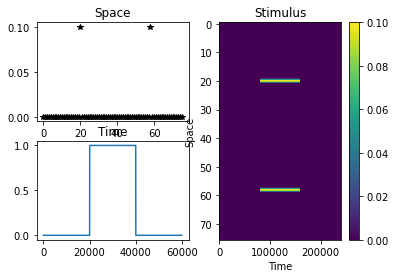

In [12]:
#Configure space and time
stimulus.configure_space()
stimulus.configure_time(numpy.arange(0., 6e4, 2**-2))

#And take a look
plot_pattern(stimulus)

In [13]:
%%time
#Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and surface.
sim = simulator.Simulator(model = oscillator, 
                          connectivity = white_matter,
                          coupling = white_matter_coupling, 
                          integrator = heunint, 
                          monitors = what_to_watch,
                          stimulus=stimulus,
                          simulation_length=6e4)

sim.configure()

   INFO  Projection configured gain shape (65, 76)
CPU times: user 292 ms, sys: 12 ms, total: 304 ms
Wall time: 320 ms


,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: c94d1faf-f499-4ab2-8649-58341dd050bb
coupling,Linear gid: b2f1e98e-023a-4ec3-8eaa-2bef1fca11a5
gid,UUID('7cabd919-ac3f-42a4-9641-b6e5283a2bee')
initial_conditions,None
integrator,HeunStochastic gid: c7ba5ca8-e571-4e51-b728-d4afd164ba56
model,Generic2dOscillator gid: 67dc0f21-d83c-41a5-a11d-dd001d9e1a72
monitors,"(, , , , )"
simulation_length,60000.0


In [14]:
%%time
(tavg_time, tavg_data), (bold_time, bold_data), (savg_time, savg_data), (eeg_time, eef_data), _ = sim.run()

   INFO  step 1 time 0.0001 s
   INFO  step 160001 time 10.0001 s
   INFO  step 320001 time 20.0001 s
   INFO  step 480001 time 30.0001 s
   INFO  step 640001 time 40.0001 s
   INFO  step 800001 time 50.0001 s
CPU times: user 20min 47s, sys: 14.4 s, total: 21min 2s
Wall time: 25min 47s


In [16]:
np.savez('std_sub_osc_01.npz', bold_time=bold_time, bold_data=bold_data,eeg_time=eeg_time, eef_data=eef_data)

Text(0.5, 1.0, 'BOLD signal')

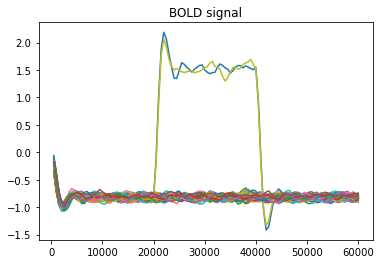

In [64]:
figure(3)
plot(bold_time[:], bold_data[:, 0, :, 0])
title("BOLD signal")

In [29]:
#Remove the 2nd and 4th axis from the array
bold = np.squeeze(bold_data, axis=(1,3))

In [30]:
bold = bold[10:,:] # remove 1st 20 points 

Text(0.5, 1.0, 'BOLD signal')

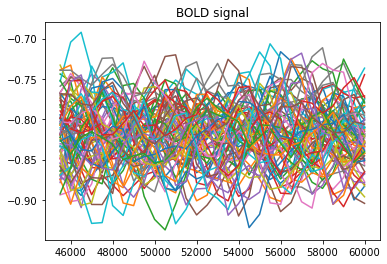

In [42]:
figure(3)
plot(bold_time[10:120], bold_data[90:120, 0, :, 0])
title("BOLD signal")

In [33]:
bold_pre = bold[:30]

In [43]:
corr_pre = np.corrcoef(bold_pre.T)

<AxesSubplot:>

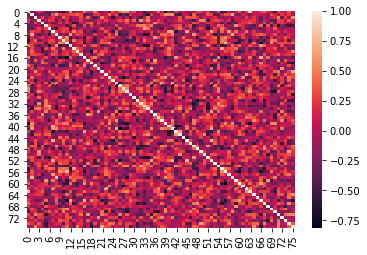

In [44]:
sns.heatmap(corr_pre)

In [47]:
corr_pre.mean()

0.012528897906173257

<AxesSubplot:>

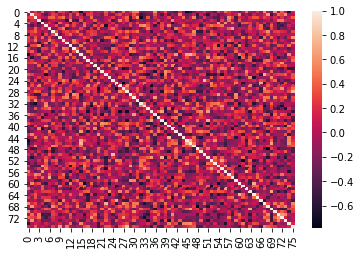

In [45]:
bold_post = bold[80:120]
corr_post = np.corrcoef(bold_post.T)
sns.heatmap(corr_post)

In [48]:
corr_post.mean()

0.010690998202668764

In [51]:
(corr_pre[20,:] + corr_pre[58:]).mean()

0.04278032233915644

In [52]:
(corr_post[20,:] + corr_post[58:]).mean()

-0.022115007568933868

In [ ]:
#np.savez('sim60e4.npz', tavg=TAVG,savg=SAVG,eeg=EEG,bavg_arr=bavg_arr)